<a href="https://colab.research.google.com/github/rajkamaludaya/cv_web_app/blob/main/TransferLearningImageClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import os,shutil

In [ ]:
  
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d sriramr/apples-bananas-oranges

# Unzip all files and suppress output
!unzip -q apples-bananas-oranges.zip 

 99% 505M/512M [00:20<00:00, 21.2MB/s]
100% 512M/512M [00:20<00:00, 26.8MB/s]


In [ ]:
# This folder contians all the class folders
main_path = 'original_data_set/original_data_set/'

In [ ]:
# all class names
import os
classnames = os.listdir(main_path)
print(classnames)

['rottenapples', 'freshapples', 'freshoranges', 'rottenoranges', 'rottenbanana', 'freshbanana']


In [ ]:
for each_class in classnames:
  print("Class: {}, has {} samples".format( each_class,len(os.listdir(os.path.join(main_path,each_class )))))

Class: rottenapples, has 328 samples
Class: freshapples, has 232 samples
Class: freshoranges, has 206 samples
Class: rottenoranges, has 222 samples
Class: rottenbanana, has 306 samples
Class: freshbanana, has 218 samples


In [ ]:
!rm -r fruits

base_dir= 'fruits'

total_train_images = 0
total_val_images = 0

os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation') 
os.mkdir(validation_dir)

# Set the percent of validation data you want.
validation_percent = 15

for each_class in classnames:

  source_directory = os.path.join(main_path,each_class )
  destination_train_directory = os.path.join(train_dir,each_class)
  destination_validation_directory = os.path.join(validation_dir,each_class)


  total_image_count = len(os.listdir(source_directory))

  valid_image_count = int(np.floor(total_image_count * (validation_percent/100)))

  train_images_count = int( total_image_count - valid_image_count )

  total_train_images +=  train_images_count
  total_val_images += valid_image_count

  os.mkdir(destination_train_directory)
  os.mkdir(destination_validation_directory)

  # copying the data to class's train folder
  file_names = os.listdir(source_directory)[:train_images_count]

  for fname in file_names:
      src = os.path.join(source_directory, fname)
      dst = os.path.join(destination_train_directory, fname)
      shutil.copyfile(src, dst)


  # Copying the data to class's validation folder
  file_names = os.listdir(source_directory)[train_images_count:]

  for fname in file_names:
      src = os.path.join(source_directory, fname)
      dst = os.path.join(destination_validation_directory, fname)
      shutil.copyfile(src, dst)
  
  print('total training {} images: {}'.format(each_class, len(os.listdir(destination_train_directory))))
  print('total validation {} images: {}'.format(each_class, len(os.listdir(destination_validation_directory))))

rm: cannot remove 'fruits': No such file or directory
total training rottenapples images: 279
total validation rottenapples images: 49
total training freshapples images: 198
total validation freshapples images: 34
total training freshoranges images: 176
total validation freshoranges images: 30
total training rottenoranges images: 189
total validation rottenoranges images: 33
total training rottenbanana images: 261
total validation rottenbanana images: 45
total training freshbanana images: 186
total validation freshbanana images: 32


In [ ]:
from tensorflow.keras.applications import VGG16

image_size = 224

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [ ]:
#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
#include_topはFully Connected Layerはロードしないという意味

# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)



# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(classnames), activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

58900480/58889256 [==============================] - 3s 0us/step
<keras.engine.input_layer.InputLayer object at 0x7f65cd563a90> False
<keras.layers.convolutional.Conv2D object at 0x7f65d3711fd0> False
<keras.layers.convolutional.Conv2D object at 0x7f65ce0d5950> False
<keras.layers.pooling.MaxPooling2D object at 0x7f65cccfa3d0> False
<keras.layers.convolutional.Conv2D object at 0x7f65ccd23550> False
<keras.layers.convolutional.Conv2D object at 0x7f65ccd2ab10> False
<keras.layers.pooling.MaxPooling2D object at 0x7f65ccd2d810> False
<keras.layers.convolutional.Conv2D object at 0x7f65c0996f50> False
<keras.layers.convolutional.Conv2D object at 0x7f65c09a1610> False
<keras.layers.convolutional.Conv2D object at 0x7f65c0996490> False
<keras.layers.pooling.MaxPooling2D object at 0x7f65c09ac250> False
<keras.layers.convolutional.Conv2D object at 0x7f65c09b0b90> False
<keras.layers.convolutional.Conv2D object at 0x7f65c09b5490> False
<keras.layers.convolutional.Conv2D object at 0x7f65c09ac710> F

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 20
val_batchsize = 2

# Data Generator for Training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')


# Data Generator for Validation data
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 1289 images belonging to 6 classes.
Found 223 images belonging to 6 classes.


In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

# Train the Model
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/20
64/64 [==============================] - 21s 157ms/step - loss: 1.0498 - acc: 0.6268 - val_loss: 0.5658 - val_acc: 0.7578
Epoch 2/20
64/64 [==============================] - 9s 144ms/step - loss: 0.4617 - acc: 0.8441 - val_loss: 0.2975 - val_acc: 0.8969
Epoch 3/20
64/64 [==============================] - 9s 143ms/step - loss: 0.2970 - acc: 0.9007 - val_loss: 0.3003 - val_acc: 0.9058
Epoch 4/20
64/64 [==============================] - 9s 143ms/step - loss: 0.2283 - acc: 0.9178 - val_loss: 0.2381 - val_acc: 0.9238
Epoch 5/20
64/64 [==============================] - 9s 143ms/step - loss: 0.1923 - acc: 0.9255 - val_loss: 0.2211 - val_acc: 0.9238
Epoch 6/20
64/64 [==============================] - 9s 144ms/step - loss: 0.1368 - acc: 0.9581 - val_loss: 0.1815 - val_acc: 0.9507
Epoch 7/20
64/64 [==============================] - 9s 143ms/step - loss: 0.1258 - acc: 0.9581 - val_loss: 0.1910 - val_acc: 0.9372
Epoch 8/20
64/64 [==============================] - 9s 143ms/step - loss: 0

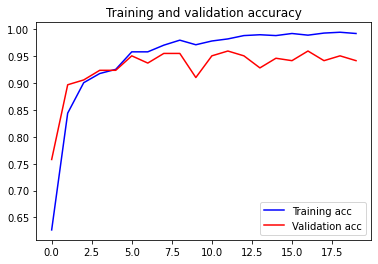

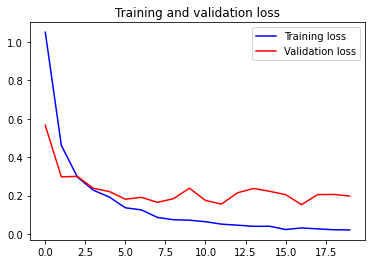

In [ ]:
# Plot the accuracy and loss curves
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


Found 223 images belonging to 6 classes.
111/111 [==============================] - 2s 14ms/step
No of errors = 13/223


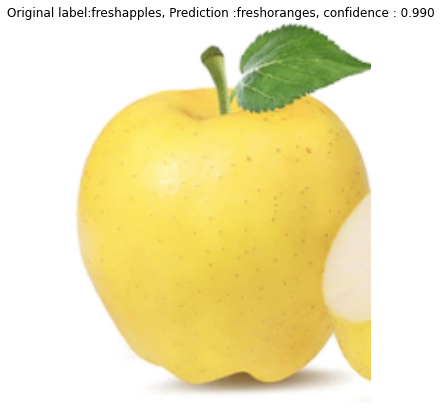

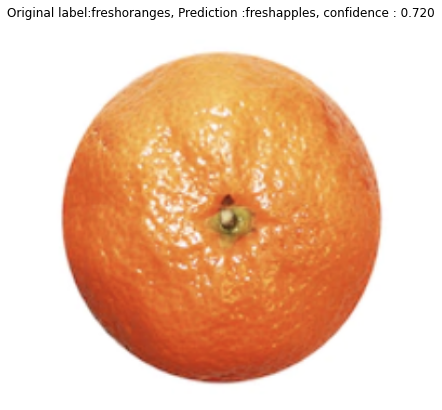

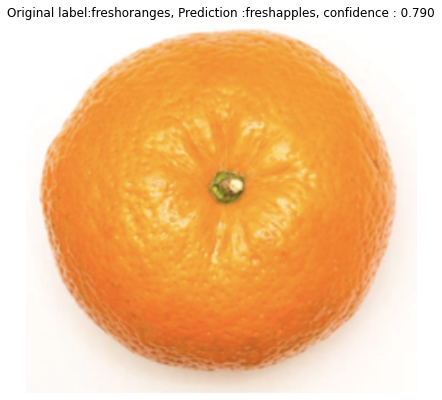

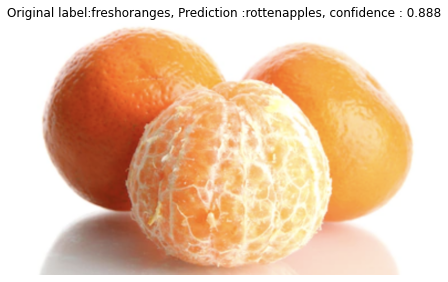

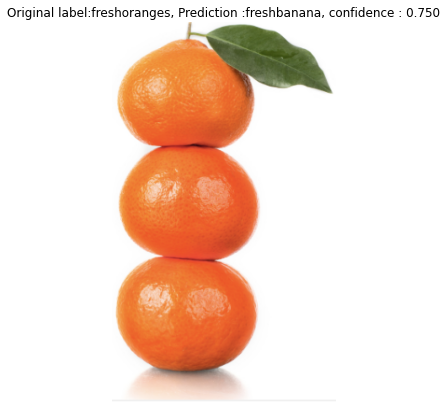

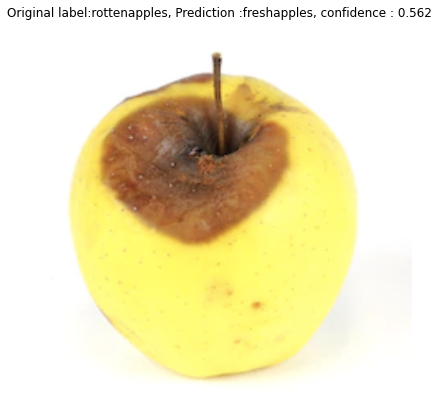

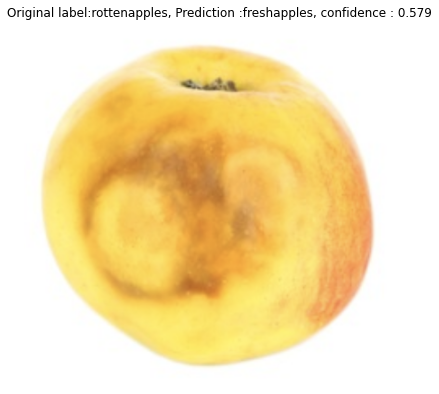

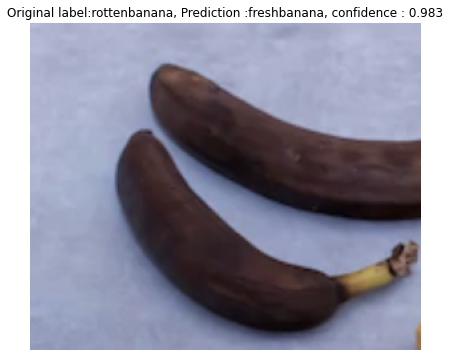

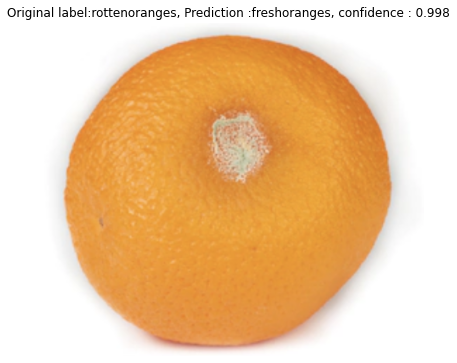

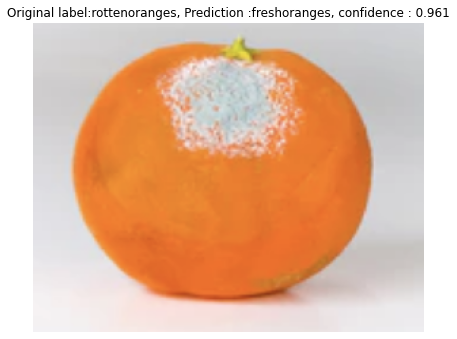

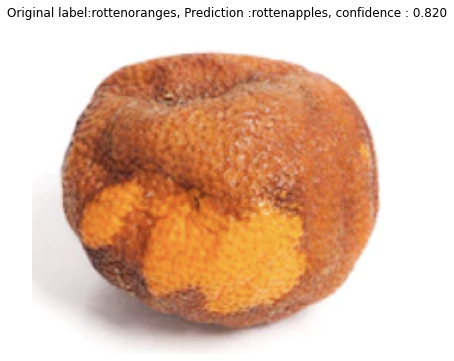

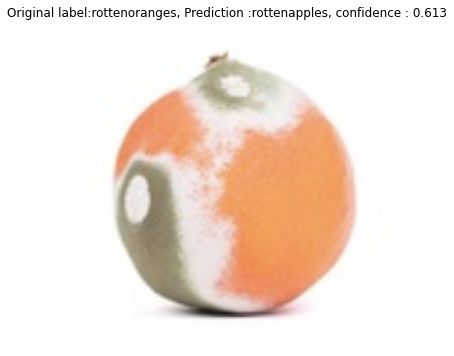

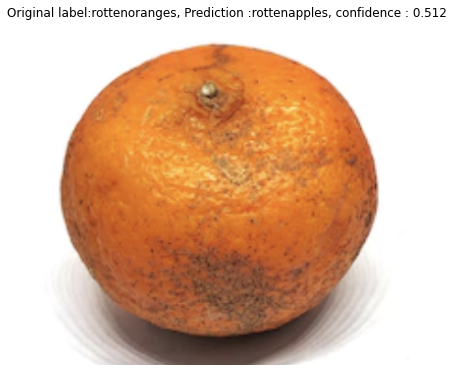

In [ ]:
# Create a generator for prediction
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Get the filenames from the generator
fnames = validation_generator.filenames

# Get the ground truth from generator
ground_truth = validation_generator.classes

# Get the label to class mapping from the generator
label2index = validation_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

# Get the predictions from the model using the generator
predictions = model.predict(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
    
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])
    
    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()

#With data augmentation

In [18]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 50
val_batchsize = 20

# Data Generator for Training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

# Data Generator for Validation data
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

# Train the Model
# NOTE that we have multiplied the steps_per_epoch by 2. This is because we are using data augmentation.
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

Found 1289 images belonging to 6 classes.
Found 223 images belonging to 6 classes.


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/20
25/25 [==============================] - 22s 792ms/step - loss: 0.4955 - acc: 0.8417 - val_loss: 0.2115 - val_acc: 0.9417
Epoch 2/20
25/25 [==============================] - 23s 910ms/step - loss: 0.3144 - acc: 0.8968 - val_loss: 0.2288 - val_acc: 0.9283
Epoch 3/20
25/25 [==============================] - 20s 780ms/step - loss: 0.2738 - acc: 0.9022 - val_loss: 0.1706 - val_acc: 0.9417
Epoch 4/20
25/25 [==============================] - 20s 782ms/step - loss: 0.2754 - acc: 0.9015 - val_loss: 0.1649 - val_acc: 0.9372
Epoch 5/20
25/25 [==============================] - 20s 776ms/step - loss: 0.2472 - acc: 0.9116 - val_loss: 0.1567 - val_acc: 0.9552
Epoch 6/20
25/25 [==============================] - 20s 777ms/step - loss: 0.2396 - acc: 0.9170 - val_loss: 0.1642 - val_acc: 0.9552
Epoch 7/20
25/25 [==============================] - 21s 803ms/step - loss: 0.2579 - acc: 0.9069 - val_loss: 0.1478 - val_acc: 0.9507
Epoch 8/20
25/25 [==============================] - 20s 782ms/step - 

In [19]:
model.save('TransferLearning.h5')

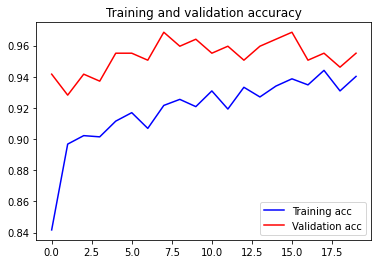

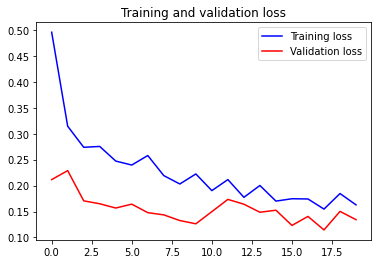

In [20]:
# Plot the accuracy and loss curves
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Found 223 images belonging to 6 classes.
11/11 [==============================] - 1s 124ms/step
No of errors = 10/223


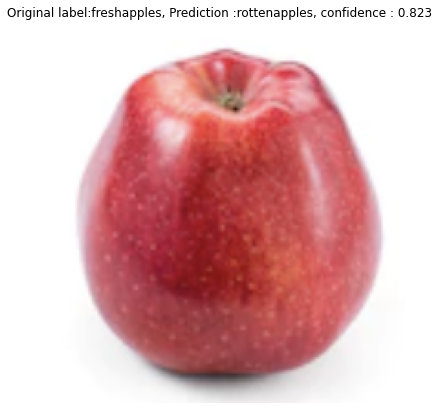

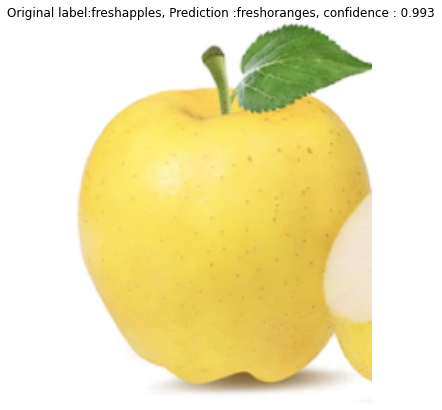

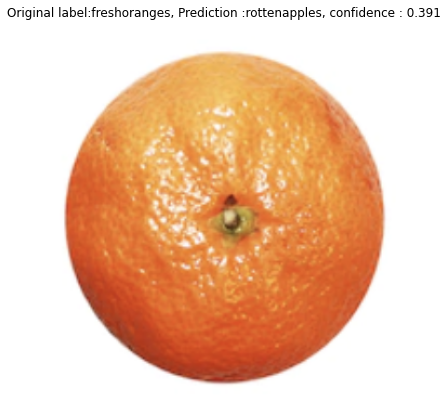

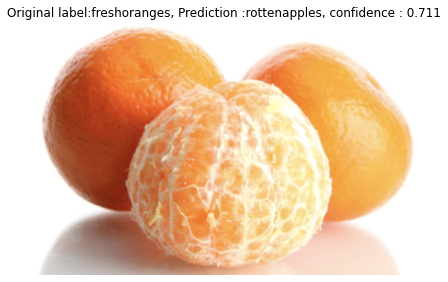

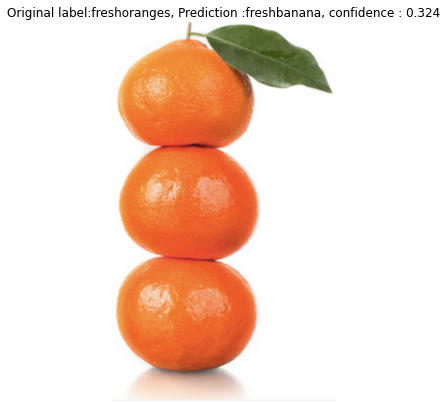

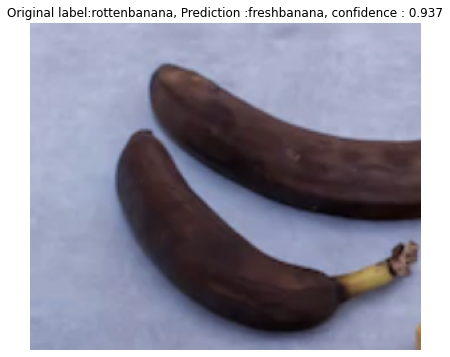

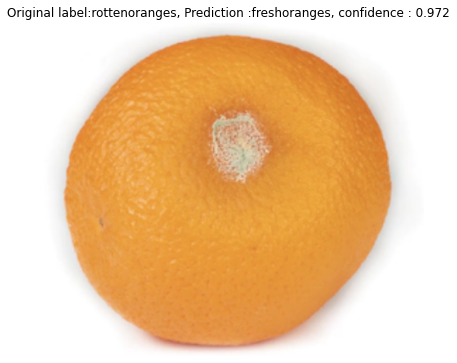

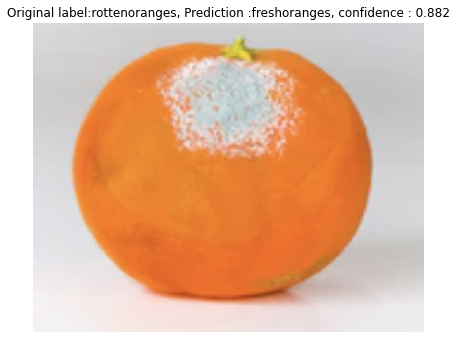

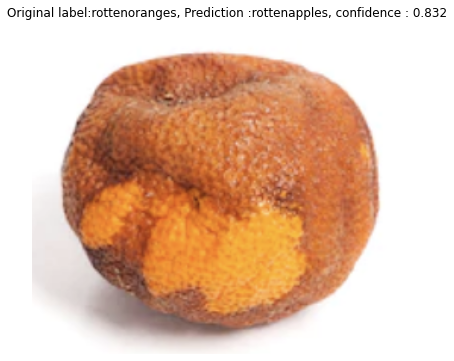

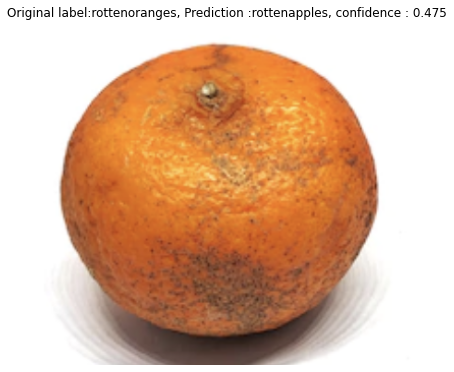

In [21]:
# Create a generator for prediction
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Get the filenames from the generator
fnames = validation_generator.filenames

# Get the ground truth from generator
ground_truth = validation_generator.classes

# Get the label to class mapping from the generator
label2index = validation_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

# Get the predictions from the model using the generator
predictions = model.predict(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
    
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])
    
    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()